# DenseNet169



In [15]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
# import package
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

In [17]:
cd /content/gdrive/MyDrive/abide_for_yilin/

/content/gdrive/MyDrive/abide_for_yilin


In [18]:
path = 'fmri/processed/autism'
images_autism = glob.glob(path + '/*.npy')

In [19]:
len(images_autism)

529

In [20]:
path = 'fmri/processed/control'
images_control = glob.glob(path + '/*.npy')

In [21]:
len(images_control)

570

In [22]:
images = images_autism + images_control

In [23]:
# create label for training
y = np.array([1]*529+[0]*570, dtype=np.int64)

In [29]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

In [25]:
import logging
import os
import sys
import tempfile
import shutil

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    ToTensor,
    Randomizable,
    LoadImaged,
    ToTensord,
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.6.dev2118
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cd6c08dfed794d2fa284418f9db8635907104365

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.60.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [26]:
# Split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2)

**DenseNet Structure**

In [41]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)),RandRotate90(), ToTensor()])
#train_transforms = Compose([ScaleIntensity(), AddChannel(), ToTensor()])
val_transforms = Compose(
    [ScaleIntensity(), AddChannel(),Resize((96, 96, 96)),ToTensor()])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=y,transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=4,
                          num_workers=2, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

# create a training data loader
train_ds = ImageDataset(
    image_files=X_train, labels=y_train,transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
                          num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(
    image_files=X_test, labels=y_test,transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=2,
                        pin_memory=torch.cuda.is_available())

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet169(
    spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 200
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} "
                "best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")
writer.close()

<class 'torch.Tensor'> torch.Size([4, 1, 96, 96, 96]) tensor([1, 1, 1, 1])
----------
epoch 1/200
epoch 1 average loss: 0.7232
----------
epoch 2/200
epoch 2 average loss: 0.7226
saved new best metric model
current epoch: 2 current accuracy: 0.5227 best accuracy: 0.5227 at epoch 2
----------
epoch 3/200
epoch 3 average loss: 0.7117
----------
epoch 4/200
epoch 4 average loss: 0.7160
saved new best metric model
current epoch: 4 current accuracy: 0.5318 best accuracy: 0.5318 at epoch 4
----------
epoch 5/200
epoch 5 average loss: 0.7156
----------
epoch 6/200
epoch 6 average loss: 0.7042
current epoch: 6 current accuracy: 0.4909 best accuracy: 0.5318 at epoch 4
----------
epoch 7/200
epoch 7 average loss: 0.7060
----------
epoch 8/200
epoch 8 average loss: 0.6993
current epoch: 8 current accuracy: 0.5182 best accuracy: 0.5318 at epoch 4
----------
epoch 9/200
epoch 9 average loss: 0.6994
----------
epoch 10/200
epoch 10 average loss: 0.6968
current epoch: 10 current accuracy: 0.5136 best

**Visualization**

**monai.metrics.occlusion_sensitivity** computes the occlusion sensitivity for a model's prediction
of a given image. Definition: how the probability of a given prediction changes as the occluded section of an image changes. This can be useful to understand why a network is making certain decisions.

The result is given as ``baseline`` (the probability of a certain output) minus the probability of the output with the occluded area.

Therefore, higher values in the output image mean there was a greater the drop in certainty, indicating the occluded region was more important in the decision process.

In [42]:
# create a validation data loader
test_ds = ImageDataset(
    image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2,
                         pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [43]:
# Get a random image and its corresponding label
img, label = get_next_im()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 92.88it/s]


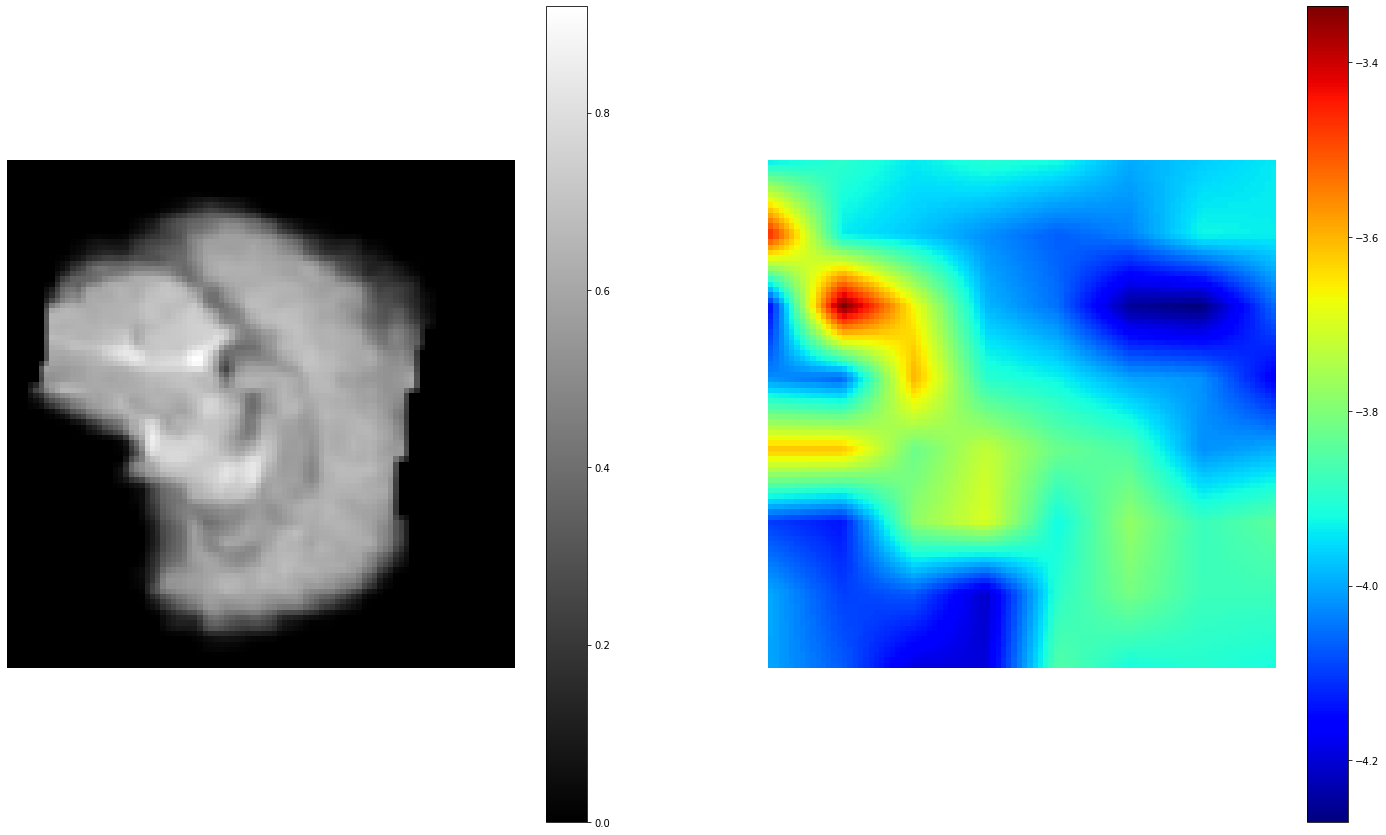

In [44]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor='white')

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = 'gray' if i == 0 else 'jet'
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis('off')
    fig.colorbar(im_show, ax=ax)